# Tutorial 4: Comparison between TensorFlow and PytorchGeometric on the SchNet Arquitecture

## Pytorch Geometric 

In [1]:
import argparse
import os.path as osp
import numpy as np
import torch
from tqdm import tqdm
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SchNet
import torch.nn as nn

In [2]:
path = '/content/qm9/'
path = './' #path de cluster
dataset = QM9(path)

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of classes: 19


De forma grafica se muestra una molecula del dataset, en este caso la que esta en el indice 121.



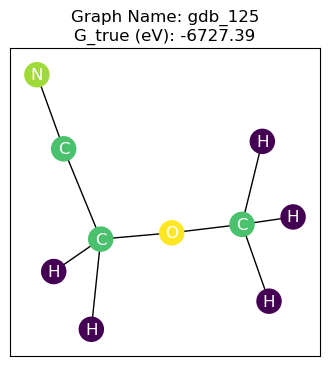

In [3]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
atomic_symbols = {
    1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne',
    11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar',
    19: 'K', 20: 'Ca'
}
data = dataset[121]
def visualize_graph(G, data, node_labels):
    plt.figure(figsize=(4,4))
    plt.xticks([])
    plt.yticks([])
    node_colors = data.x.numpy()[:, 5]

    pos = nx.spring_layout(G, seed=42)
    nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
    plt.title(f"Graph Name: {data.name}\nG_true (eV): {np.round(data.y.numpy()[0,10], 2):.2f}")
    plt.show()

# Convertir el gráfico a NetworkX
G = to_networkx(data, to_undirected=True)
# Crear etiquetas para los nodos (usando el número atómico en este caso)
node_labels = {i: atomic_symbols.get(int(data.x[i, 5].item()), '?') for i in range(data.num_nodes)}

visualize_graph(G, data, node_labels)

Se crea un funcion run para ejecutar de forma iterativa el entrenamiento de la red

In [8]:
global target_mean, target_std
def run(hidden_channels=64, num_filters=64, num_interactions=6, num_gaussians=300, 
        cutoff = 30.0, lr=1e-3, num_epochs=200):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset, val_dataset, test_dataset = dataset[:110000],\
                                               dataset[110000:120000],\
                                               dataset[120000:len(dataset)]
    #train_dataset, val_dataset, test_dataset = dataset[:3000], dataset[3000:4000], dataset[4000:5000]
    target_mean, target_std = train_dataset.mean(target=10), train_dataset.std(target=10)
    net = SchNet(
                hidden_channels=hidden_channels, #embedding layer
                num_filters=num_filters, #channels
                num_interactions=num_interactions, #capas de interaccion
                num_gaussians=num_gaussians,
                cutoff=cutoff
            )
    model = net.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)
    loss_mse = nn.MSELoss(reduction='mean')
    loss_mae = nn.L1Loss()

    train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True) #before 100
    val_loader = DataLoader(val_dataset, batch_size=200, shuffle=True) #before 100
    test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True) #before 100

    def train(data_loader):
        model.train()
        total_loss_mse, total_loss_mae = 0, 0
        for idx, batch in enumerate(data_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.z, batch.pos, batch.batch)
            norm_vals = (batch.y[:,10]-target_mean)/target_std
            loss = loss_mse(out, norm_vals.unsqueeze(-1))
            loss2 = loss_mae((out*target_std)+target_mean, batch.y[:, 10].unsqueeze(-1))
            loss.backward()
            optimizer.step()
            total_loss_mse += loss.item()
            total_loss_mae += loss2.item()
        return total_loss_mse / len(data_loader), total_loss_mae / len(data_loader)

    def test(data_loader, val=True):
        model.eval()
        total_loss_mse, total_loss_mae = 0, 0
        with torch.no_grad():
            for idx, batch in enumerate(data_loader):
                batch = batch.to(device)
                out = model(batch.z, batch.pos, batch.batch)
                if val:
                    norm_vals = (batch.y[:,10]-target_mean)/target_std
                    loss = loss_mse(out, norm_vals.unsqueeze(-1))
                else:
                    loss = loss_mse((out*target_std)+target_mean, batch.y[:, 10].unsqueeze(-1))
                loss2 = loss_mae((out*target_std)+target_mean, batch.y[:, 10].unsqueeze(-1))
                total_loss_mse += loss.item()
                total_loss_mae += loss2.item()
        return total_loss_mse / len(data_loader), total_loss_mae / len(data_loader)

    history = {'train_mse':[], 'val_mse':[], 'train_mae':[], 'val_mae':[]}
    for epoch in range(1, num_epochs+1):
        loss_train, loss2_train = train(train_loader)
        loss_val, loss2_val = test(val_loader,val=True)
        lr_scheduler.step()
        
        history['train_mse'].append(loss_train)
        history['val_mse'].append(loss_val)
        history['train_mae'].append(loss2_train)
        history['val_mae'].append(loss2_val)

        print(f'Epoch: {epoch:03d} Train(MSE) {loss_train:.2e} Val(MSE) {loss_val:.2e} Train(MAE) {loss2_train:.2f} Val(MAE) {loss2_val:.2f}')

        torch.cuda.empty_cache()

    loss_test, loss2_test = test(test_loader,val=False)
    print(f'Test(MSE) {loss_test:.2e}, Test(MAE) {loss2_test:.2f}')
    return history, loss_test, loss2_test

interactions blocks 3
Epoch: 001 Train(MSE) 1.22e+00 Val(MSE) 3.31e-02 Train(MAE) 418.80 Val(MAE) 149.56
Epoch: 002 Train(MSE) 3.10e-02 Val(MSE) 2.64e-02 Train(MAE) 108.74 Val(MAE) 145.26
Epoch: 003 Train(MSE) 2.14e-02 Val(MSE) 6.83e-03 Train(MAE) 89.36 Val(MAE) 68.60
Epoch: 004 Train(MSE) 1.49e-02 Val(MSE) 1.54e-02 Train(MAE) 73.84 Val(MAE) 111.59
Epoch: 005 Train(MSE) 1.44e-02 Val(MSE) 4.31e-02 Train(MAE) 81.37 Val(MAE) 206.41
Test(MSE) 3.78e+04, Test(MAE) 175.58


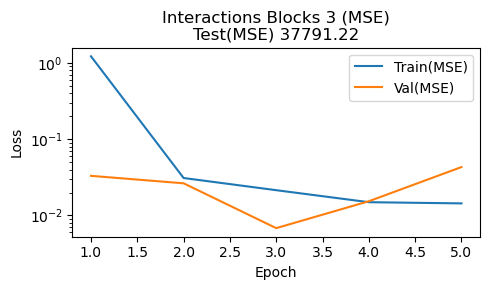

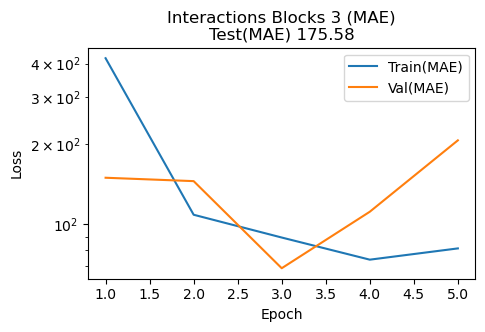

In [9]:
#Test script
for val in [3]:
    print(f'interactions blocks {val}')
    history, loss_test, loss2_test = run(num_interactions=val, num_epochs=5)
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mse'])+1),history['train_mse'],label='Train(MSE)')
    plt.plot(range(1,len(history['val_mse'])+1),history['val_mse'],label='Val(MSE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Interactions Blocks {val} (MSE)\nTest(MSE) {loss_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_intblocksMSE_test.png')
    
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mae'])+1),history['train_mae'],label='Train(MAE)')
    plt.plot(range(1,len(history['val_mae'])+1),history['val_mae'],label='Val(MAE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Interactions Blocks {val} (MAE)\nTest(MAE) {loss2_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_intblocksMAE_test.png')

In [ ]:
#Variar interactions blocks
for val in [3,4,5,6]:
    
    print(f'interactions blocks {val}')
    history, loss_test, loss2_test = run(num_interactions=val, num_epochs=400)
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mse'])+1),history['train_mse'],label='Train(MSE)')
    plt.plot(range(1,len(history['val_mse'])+1),history['val_mse'],label='Val(MSE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Interactions Blocks {val} (MSE)\nTest(MSE) {loss_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_intblocks{val}_MSE.png')
    
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mae'])+1),history['train_mae'],label='Train(MAE)')
    plt.plot(range(1,len(history['val_mae'])+1),history['val_mae'],label='Val(MAE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Interactions Blocks {val} (MAE)\nTest(MAE) {loss2_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_intblocks{val}_MAE.png')

interactions blocks 3
Epoch: 001 Train(MSE) 4.81e-01 Val(MSE) 1.27e-02 Train(MAE) 334.45 Val(MAE) 94.41
Epoch: 002 Train(MSE) 3.16e-02 Val(MSE) 2.08e-02 Train(MAE) 121.40 Val(MAE) 135.92
Epoch: 003 Train(MSE) 2.08e-02 Val(MSE) 7.96e-03 Train(MAE) 100.63 Val(MAE) 78.57
Epoch: 004 Train(MSE) 1.77e-02 Val(MSE) 4.75e-03 Train(MAE) 97.40 Val(MAE) 58.63
Epoch: 005 Train(MSE) 1.41e-02 Val(MSE) 2.54e-02 Train(MAE) 83.95 Val(MAE) 156.61
Epoch: 006 Train(MSE) 1.34e-02 Val(MSE) 2.70e-03 Train(MAE) 81.43 Val(MAE) 44.41
Epoch: 007 Train(MSE) 1.24e-02 Val(MSE) 2.97e-02 Train(MAE) 81.98 Val(MAE) 177.24
Epoch: 008 Train(MSE) 1.36e-02 Val(MSE) 1.26e-02 Train(MAE) 87.14 Val(MAE) 109.41
Epoch: 009 Train(MSE) 7.57e-03 Val(MSE) 7.46e-04 Train(MAE) 65.37 Val(MAE) 22.50
Epoch: 010 Train(MSE) 1.00e-02 Val(MSE) 1.50e-03 Train(MAE) 77.21 Val(MAE) 32.78
Epoch: 011 Train(MSE) 8.35e-03 Val(MSE) 3.97e-03 Train(MAE) 70.85 Val(MAE) 61.72
Epoch: 012 Train(MSE) 8.65e-03 Val(MSE) 8.59e-04 Train(MAE) 69.18 Val(MAE) 24.16

Epoch: 103 Train(MSE) 1.96e-04 Val(MSE) 9.13e-05 Train(MAE) 10.94 Val(MAE) 8.26
Epoch: 104 Train(MSE) 1.88e-04 Val(MSE) 1.89e-04 Train(MAE) 11.14 Val(MAE) 12.24
Epoch: 105 Train(MSE) 2.87e-04 Val(MSE) 1.17e-04 Train(MAE) 11.89 Val(MAE) 10.02
Epoch: 106 Train(MSE) 1.75e-04 Val(MSE) 3.13e-04 Train(MAE) 9.40 Val(MAE) 17.10
Epoch: 107 Train(MSE) 1.65e-04 Val(MSE) 6.28e-05 Train(MAE) 10.33 Val(MAE) 7.01
Epoch: 108 Train(MSE) 1.96e-04 Val(MSE) 1.09e-04 Train(MAE) 10.58 Val(MAE) 10.24
Epoch: 109 Train(MSE) 1.62e-04 Val(MSE) 7.78e-04 Train(MAE) 10.11 Val(MAE) 28.12
Epoch: 110 Train(MSE) 2.02e-04 Val(MSE) 1.30e-04 Train(MAE) 10.91 Val(MAE) 8.67
Epoch: 111 Train(MSE) 2.04e-04 Val(MSE) 6.53e-04 Train(MAE) 10.58 Val(MAE) 25.37
Epoch: 112 Train(MSE) 1.39e-04 Val(MSE) 1.33e-04 Train(MAE) 9.11 Val(MAE) 11.11
Epoch: 113 Train(MSE) 1.55e-04 Val(MSE) 2.13e-04 Train(MAE) 9.48 Val(MAE) 14.28
Epoch: 114 Train(MSE) 1.51e-04 Val(MSE) 4.11e-05 Train(MAE) 10.13 Val(MAE) 5.61
Epoch: 115 Train(MSE) 2.05e-04 Val(

Epoch: 207 Train(MSE) 2.83e-05 Val(MSE) 5.26e-06 Train(MAE) 4.16 Val(MAE) 1.84
Epoch: 208 Train(MSE) 2.29e-05 Val(MSE) 9.02e-05 Train(MAE) 3.91 Val(MAE) 9.20
Epoch: 209 Train(MSE) 2.27e-05 Val(MSE) 4.83e-05 Train(MAE) 3.91 Val(MAE) 6.81
Epoch: 210 Train(MSE) 2.30e-05 Val(MSE) 8.90e-06 Train(MAE) 3.91 Val(MAE) 2.55
Epoch: 211 Train(MSE) 2.50e-05 Val(MSE) 1.16e-04 Train(MAE) 4.09 Val(MAE) 10.81
Epoch: 212 Train(MSE) 2.46e-05 Val(MSE) 1.34e-04 Train(MAE) 3.88 Val(MAE) 10.91
Epoch: 213 Train(MSE) 2.31e-05 Val(MSE) 5.80e-05 Train(MAE) 3.84 Val(MAE) 7.60
Epoch: 214 Train(MSE) 2.41e-05 Val(MSE) 2.36e-05 Train(MAE) 3.90 Val(MAE) 4.60
Epoch: 215 Train(MSE) 2.51e-05 Val(MSE) 1.90e-05 Train(MAE) 3.97 Val(MAE) 3.60
Epoch: 216 Train(MSE) 2.97e-05 Val(MSE) 1.21e-05 Train(MAE) 4.03 Val(MAE) 2.87
Epoch: 217 Train(MSE) 2.19e-05 Val(MSE) 8.09e-06 Train(MAE) 3.78 Val(MAE) 2.46
Epoch: 218 Train(MSE) 2.33e-05 Val(MSE) 3.92e-05 Train(MAE) 3.97 Val(MAE) 6.14
Epoch: 219 Train(MSE) 1.89e-05 Val(MSE) 6.74e-06 T

Epoch: 311 Train(MSE) 5.62e-06 Val(MSE) 4.45e-06 Train(MAE) 1.90 Val(MAE) 1.75
Epoch: 312 Train(MSE) 5.65e-06 Val(MSE) 9.13e-06 Train(MAE) 1.90 Val(MAE) 2.82
Epoch: 313 Train(MSE) 5.71e-06 Val(MSE) 8.03e-06 Train(MAE) 1.94 Val(MAE) 2.54
Epoch: 314 Train(MSE) 5.51e-06 Val(MSE) 2.53e-06 Train(MAE) 1.90 Val(MAE) 1.25
Epoch: 315 Train(MSE) 5.83e-06 Val(MSE) 3.27e-06 Train(MAE) 1.95 Val(MAE) 1.50
Epoch: 316 Train(MSE) 5.42e-06 Val(MSE) 3.45e-06 Train(MAE) 1.86 Val(MAE) 1.52
Epoch: 317 Train(MSE) 5.45e-06 Val(MSE) 2.49e-06 Train(MAE) 1.88 Val(MAE) 1.24
Epoch: 318 Train(MSE) 6.45e-06 Val(MSE) 5.66e-06 Train(MAE) 1.99 Val(MAE) 2.07
Epoch: 319 Train(MSE) 5.91e-06 Val(MSE) 3.36e-06 Train(MAE) 1.77 Val(MAE) 1.51
Epoch: 320 Train(MSE) 6.30e-06 Val(MSE) 6.12e-06 Train(MAE) 2.00 Val(MAE) 2.19
Epoch: 321 Train(MSE) 4.79e-06 Val(MSE) 4.96e-06 Train(MAE) 1.73 Val(MAE) 1.80
Epoch: 322 Train(MSE) 5.51e-06 Val(MSE) 2.78e-06 Train(MAE) 1.90 Val(MAE) 1.30
Epoch: 323 Train(MSE) 4.93e-06 Val(MSE) 6.47e-06 Tra

Epoch: 014 Train(MSE) 6.93e-03 Val(MSE) 6.22e-04 Train(MAE) 65.96 Val(MAE) 20.49
Epoch: 015 Train(MSE) 5.99e-03 Val(MSE) 5.42e-04 Train(MAE) 57.28 Val(MAE) 19.17
Epoch: 016 Train(MSE) 5.30e-03 Val(MSE) 3.93e-03 Train(MAE) 59.40 Val(MAE) 60.44
Epoch: 017 Train(MSE) 5.17e-03 Val(MSE) 3.13e-02 Train(MAE) 55.82 Val(MAE) 183.52
Epoch: 018 Train(MSE) 5.08e-03 Val(MSE) 5.74e-04 Train(MAE) 56.72 Val(MAE) 19.97
Epoch: 019 Train(MSE) 4.44e-03 Val(MSE) 1.03e-02 Train(MAE) 50.68 Val(MAE) 103.33
Epoch: 020 Train(MSE) 3.75e-03 Val(MSE) 3.48e-03 Train(MAE) 45.55 Val(MAE) 54.00
Epoch: 021 Train(MSE) 4.40e-03 Val(MSE) 3.69e-04 Train(MAE) 49.50 Val(MAE) 16.28
Epoch: 022 Train(MSE) 3.06e-03 Val(MSE) 2.49e-04 Train(MAE) 44.03 Val(MAE) 12.81
Epoch: 023 Train(MSE) 3.42e-03 Val(MSE) 4.88e-04 Train(MAE) 49.26 Val(MAE) 18.84
Epoch: 024 Train(MSE) 2.70e-03 Val(MSE) 1.38e-03 Train(MAE) 40.97 Val(MAE) 35.98
Epoch: 025 Train(MSE) 3.47e-03 Val(MSE) 4.21e-03 Train(MAE) 47.59 Val(MAE) 65.92
Epoch: 026 Train(MSE) 2.30

Epoch: 116 Train(MSE) 1.39e-04 Val(MSE) 5.81e-05 Train(MAE) 9.30 Val(MAE) 6.41
Epoch: 117 Train(MSE) 1.24e-04 Val(MSE) 2.80e-04 Train(MAE) 9.05 Val(MAE) 16.49
Epoch: 118 Train(MSE) 1.30e-04 Val(MSE) 3.04e-05 Train(MAE) 9.12 Val(MAE) 4.48
Epoch: 119 Train(MSE) 1.06e-04 Val(MSE) 6.70e-05 Train(MAE) 8.23 Val(MAE) 7.26
Epoch: 120 Train(MSE) 1.56e-04 Val(MSE) 2.53e-05 Train(MAE) 8.68 Val(MAE) 4.17
Epoch: 121 Train(MSE) 1.00e-04 Val(MSE) 2.58e-04 Train(MAE) 8.05 Val(MAE) 15.43
Epoch: 122 Train(MSE) 1.39e-04 Val(MSE) 5.13e-05 Train(MAE) 9.16 Val(MAE) 6.15
Epoch: 123 Train(MSE) 9.89e-05 Val(MSE) 5.66e-05 Train(MAE) 8.15 Val(MAE) 6.41
Epoch: 124 Train(MSE) 1.04e-04 Val(MSE) 1.37e-05 Train(MAE) 8.20 Val(MAE) 3.04
Epoch: 125 Train(MSE) 1.43e-04 Val(MSE) 6.78e-05 Train(MAE) 9.47 Val(MAE) 7.47
Epoch: 126 Train(MSE) 1.49e-04 Val(MSE) 5.14e-05 Train(MAE) 8.67 Val(MAE) 6.67
Epoch: 127 Train(MSE) 7.84e-05 Val(MSE) 1.67e-04 Train(MAE) 6.54 Val(MAE) 13.07
Epoch: 128 Train(MSE) 1.10e-04 Val(MSE) 1.28e-05 

Epoch: 220 Train(MSE) 2.71e-05 Val(MSE) 3.26e-05 Train(MAE) 3.89 Val(MAE) 5.47
Epoch: 221 Train(MSE) 2.46e-05 Val(MSE) 4.24e-05 Train(MAE) 3.68 Val(MAE) 5.98
Epoch: 222 Train(MSE) 1.80e-05 Val(MSE) 8.03e-06 Train(MAE) 3.38 Val(MAE) 2.41
Epoch: 223 Train(MSE) 1.69e-05 Val(MSE) 2.31e-05 Train(MAE) 3.25 Val(MAE) 4.17
Epoch: 224 Train(MSE) 1.78e-05 Val(MSE) 6.74e-06 Train(MAE) 3.34 Val(MAE) 2.12
Epoch: 225 Train(MSE) 1.76e-05 Val(MSE) 5.68e-06 Train(MAE) 3.32 Val(MAE) 1.94
Epoch: 226 Train(MSE) 1.53e-05 Val(MSE) 2.06e-04 Train(MAE) 3.19 Val(MAE) 14.88
Epoch: 227 Train(MSE) 1.83e-05 Val(MSE) 1.37e-05 Train(MAE) 3.33 Val(MAE) 3.26
Epoch: 228 Train(MSE) 1.66e-05 Val(MSE) 2.38e-05 Train(MAE) 3.21 Val(MAE) 4.55
Epoch: 229 Train(MSE) 1.75e-05 Val(MSE) 4.26e-05 Train(MAE) 3.28 Val(MAE) 6.39
Epoch: 230 Train(MSE) 1.81e-05 Val(MSE) 5.77e-06 Train(MAE) 3.39 Val(MAE) 1.95
Epoch: 231 Train(MSE) 1.58e-05 Val(MSE) 5.15e-06 Train(MAE) 3.11 Val(MAE) 1.84
Epoch: 232 Train(MSE) 1.52e-05 Val(MSE) 3.40e-05 Tr

Epoch: 324 Train(MSE) 4.77e-06 Val(MSE) 3.77e-06 Train(MAE) 1.77 Val(MAE) 1.63
Epoch: 325 Train(MSE) 5.11e-06 Val(MSE) 7.44e-06 Train(MAE) 1.83 Val(MAE) 2.43
Epoch: 326 Train(MSE) 4.80e-06 Val(MSE) 5.15e-06 Train(MAE) 1.72 Val(MAE) 1.96
Epoch: 327 Train(MSE) 4.56e-06 Val(MSE) 3.82e-06 Train(MAE) 1.71 Val(MAE) 1.57
Epoch: 328 Train(MSE) 4.64e-06 Val(MSE) 4.09e-06 Train(MAE) 1.73 Val(MAE) 1.66
Epoch: 329 Train(MSE) 4.91e-06 Val(MSE) 2.76e-06 Train(MAE) 1.75 Val(MAE) 1.32
Epoch: 330 Train(MSE) 4.24e-06 Val(MSE) 2.40e-06 Train(MAE) 1.66 Val(MAE) 1.23
Epoch: 331 Train(MSE) 4.66e-06 Val(MSE) 3.27e-06 Train(MAE) 1.71 Val(MAE) 1.46
Epoch: 332 Train(MSE) 4.18e-06 Val(MSE) 2.60e-06 Train(MAE) 1.61 Val(MAE) 1.28
Epoch: 333 Train(MSE) 4.90e-06 Val(MSE) 1.76e-05 Train(MAE) 1.78 Val(MAE) 4.07
Epoch: 334 Train(MSE) 3.96e-06 Val(MSE) 2.65e-06 Train(MAE) 1.59 Val(MAE) 1.30
Epoch: 335 Train(MSE) 4.33e-06 Val(MSE) 7.29e-06 Train(MAE) 1.68 Val(MAE) 2.41
Epoch: 336 Train(MSE) 4.21e-06 Val(MSE) 3.08e-06 Tra

In [ ]:
#Variar filters
for val in [32,64,128]:
    print(f'filters {val}')

    history, loss_test, loss2_test = run(num_interactions=6, num_filters=val, num_epochs=400)
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mse'])+1),history['train_mse'],label='Train(MSE)')
    plt.plot(range(1,len(history['val_mse'])+1),history['val_mse'],label='Val(MSE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Filters {val} (MSE)\nTest(MSE) {loss_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_filters{val}_MSE.png')
    
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mae'])+1),history['train_mae'],label='Train(MAE)')
    plt.plot(range(1,len(history['val_mae'])+1),history['val_mae'],label='Val(MAE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Filters {val} (MAE)\nTest(MAE) {loss2_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_filters{val}_MAE.png')

In [ ]:
#Variar interactions blocks
for val in [100,200,300]:
    
    print(f'gaussians {val}')

    history, loss_test, loss2_test = run(num_interactions=6, num_gaussians=val, num_epochs=400)
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mse'])+1),history['train_mse'],label='Train(MSE)')
    plt.plot(range(1,len(history['val_mse'])+1),history['val_mse'],label='Val(MSE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Gaussians {val} (MSE)\nTest(MSE) {loss_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_gaussians{val}_MSE.png')
    
    plt.figure(figsize=(5,3))
    plt.plot(range(1,len(history['train_mae'])+1),history['train_mae'],label='Train(MAE)')
    plt.plot(range(1,len(history['val_mae'])+1),history['val_mae'],label='Val(MAE)')
    plt.yscale('log'); plt.ylabel('Loss'); plt.xlabel('Epoch')
    plt.title(f'Gaussians {val} (MAE)\nTest(MAE) {loss2_test:.2f}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'history_gaussians{val}_MAE.png')

In [ ]:
##Testeo
data = dataset[121]
data.z = data.z.to(device)
data.pos = data.pos.to(device)
model.eval()
# Convertir el gráfico a NetworkX
G = to_networkx(data, to_undirected=True)
# Crear etiquetas para los nodos (usando el número atómico en este caso)
node_labels = {i: atomic_symbols.get(int(data.x[i, 5].item()), '?') for i in range(data.num_nodes)}
# Crear etiquetas para los nodos (usando el número atómico en este caso)
plt.figure(figsize=(4,4))
plt.xticks([])
plt.yticks([])
node_colors = data.x.numpy()[:, 5]

pos = nx.spring_layout(G, seed=42)
nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=42), node_color=node_colors)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
val = model.forward(data.z, data.pos)[0][0].item()
val = val*target_std+target_mean
plt.title(f"Graph Name: {data.name}\nG_True (eV): {np.round(data.y.numpy()[0,10], 2):.2f}\nG_Predicted (eV): {np.round(val, 2):.2f}")
plt.show()


## TensorFlow 

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import networkx as nx
from torch_geometric.datasets import QM9

In [2]:
path = '/content/qm9/'
path = '/mnt/lustre/scratch/nlsas/home/res/uam82/uam82205/ML4molecularSims/Notebooks/4_Comparison_lib/' #path de cluster
dataset = QM9(path)

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

train_dataset, test_dataset = dataset[:120000],\
                              dataset[120000:len(dataset)]

Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of classes: 19


/home/res/uam82/uam82205/.local/lib/python3.7/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


count    130831.000000
mean     -11180.287109
std        1085.403931
min      -19445.314453
25%      -11916.187500
50%      -11342.830078
75%      -10532.833984
max       -1102.022949
Name: G (train) , dtype: float64

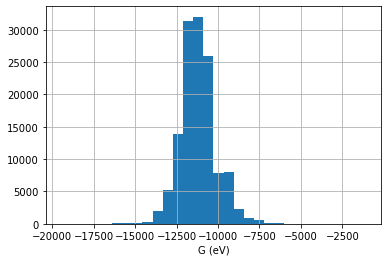

In [3]:
G_train = pd.Series(train_dataset.data.y[:,10].numpy(), name='G (train) ')
stats_G_train = G_train.describe()
display(G_train.describe())

G_test = pd.Series(test_dataset.data.y[:,10].numpy(), name='G (test)')
stats_G_test = G_test.describe()

ax = G_train.hist(bins=30)
_ = ax.set_xlabel('G (eV)')

def norm_energy(val,stats):
    return (val-stats.mean())/stats.std()

def unnorm_energy(val,stats):
    return val*stats.std()+stats.mean()

In [4]:
def generator():
      for j in range(len(train_dataset)):
            G = np.array([train_dataset[j].y.numpy()[0][10]])
            yield train_dataset[j].pos.numpy(), train_dataset[j].z.numpy(), norm_energy(G, stats_G_train)

def generator_test():
      for j in range(len(test_dataset)):
            G = np.array([test_dataset[j].y.numpy()[0][10]])
            yield test_dataset[j].pos.numpy(), test_dataset[j].z.numpy(), G

data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
)
test_data = tf.data.Dataset.from_generator(
    generator_test,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(1), dtype=tf.float32)
    ),
)

train_data = data.take(110000)
val_data = data.skip(110000).take(10000)

Cambiar de dataset a graph dataset

In [5]:

def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0] #number of points
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # add dim extra at 1
    qTexpand = tf.expand_dims(positions, 0)  # add dim extra at 0
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1]) #repeat M times
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype) #matriz 0 y 1
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

MAX_DEGREE = 30 #cantidad de vecinos a un atomo dado
EDGE_FEATURES = 300 #cantidad de caracteristicas por distancia
MAX_R = 30 #hiperparametro de rbf

gamma = 10
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y, z):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    return (y, edge_features, edge_i), z

graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)


In [7]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp),
         tf.keras.layers.Dense(units, activation=ssp)])

def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )

class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(60, channels) #transform to 1 to channels
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            # get the node features per edge
            v_sk = tf.gather(nodes, edge_i) #choose closest atoms
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features) #calculate directions of update atoms
            e_i = tf.reduce_sum(e_k, axis=1) #compute sum over all closest atoms
            nodes += self.h3s[i](e_i) #update node feature. The edge feature are not updated
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0) #invariant operation

In [8]:
small_schnet = SchNetModel(6, 64) #3 capas 64 canales

In [ ]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae']
)
# Train your model
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=20)

Epoch 1/20
110000/110000 [==============================] - 508s 5ms/step - loss: 8.3030e-06 - mae: 0.0016 - val_loss: 9.8710e-06 - val_mae: 0.0025
Epoch 2/20
110000/110000 [==============================] - 514s 5ms/step - loss: 7.5424e-06 - mae: 9.7501e-04 - val_loss: 2.0861e-06 - val_mae: 0.0012
Epoch 3/20
110000/110000 [==============================] - 525s 5ms/step - loss: 1.7099e-05 - mae: 6.5824e-04 - val_loss: 5.4103e-07 - val_mae: 6.0939e-04
Epoch 4/20
110000/110000 [==============================] - 529s 5ms/step - loss: 3.1302e-06 - mae: 4.9086e-04 - val_loss: 2.3358e-07 - val_mae: 3.6803e-04
Epoch 5/20
110000/110000 [==============================] - 518s 5ms/step - loss: 2.9778e-06 - mae: 4.5697e-04 - val_loss: 1.5567e-07 - val_mae: 3.2461e-04
Epoch 6/20
110000/110000 [==============================] - 529s 5ms/step - loss: 2.7646e-06 - mae: 4.3209e-04 - val_loss: 5.5780e-08 - val_mae: 1.3423e-04
Epoch 7/20
110000/110000 [==============================] - 517s 5ms/step - 

In [ ]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3), loss='mse', metrics=['mae']
)
# Train your model
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=100)

Epoch 1/100
110000/110000 [==============================] - 360s 3ms/step - loss: 7.7259e-06 - mae: 9.8515e-04 - val_loss: 1.4511e-06 - val_mae: 9.2553e-04
Epoch 2/100
110000/110000 [==============================] - 333s 3ms/step - loss: 4.7118e-06 - mae: 8.4157e-04 - val_loss: 1.1911e-06 - val_mae: 7.9767e-04
Epoch 3/100
110000/110000 [==============================] - 317s 3ms/step - loss: 4.5085e-06 - mae: 7.6707e-04 - val_loss: 1.8409e-06 - val_mae: 0.0011
Epoch 4/100
110000/110000 [==============================] - 320s 3ms/step - loss: 4.4310e-06 - mae: 7.1538e-04 - val_loss: 2.4190e-06 - val_mae: 0.0012
Epoch 5/100
110000/110000 [==============================] - 318s 3ms/step - loss: 4.3938e-06 - mae: 6.7574e-04 - val_loss: 3.2405e-06 - val_mae: 0.0015
Epoch 6/100
110000/110000 [==============================] - 322s 3ms/step - loss: 4.4520e-06 - mae: 6.4280e-04 - val_loss: 2.7712e-06 - val_mae: 0.0013
Epoch 7/100
110000/110000 [==============================] - 314s 3ms/step

In [ ]:
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
mae = 0
for i, (x, y) in enumerate(graph_test_data):
    yhat = unnorm_energy(small_schnet(x), stats_G_train)
    mae += abs(yhat[0] - y.numpy()[0])
print(f'MAE (Test set): {mae/(i+1)}')

In [ ]:
mae = 0
for i, (x, y) in enumerate(graph_train_data):
    yhat = unnorm_energy(small_schnet(x), stats_G_train)
    mae += abs(yhat[0] - y.numpy()[0])
print(f'MAE (Train set): {mae/(i+1)}')

mae = 0
for i, (x, y) in enumerate(graph_val_data):
    yhat = unnorm_energy(small_schnet(x), stats_G_train)
    mae += abs(yhat[0] - y.numpy()[0])
print(f'MAE (val set): {mae/(i+1)}')